In [32]:
#%pip install pyarrow
#%pip install scikit-learn
# %pip install keras
# %pip install tensorflow

In [33]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [34]:
df=pd.read_parquet(r"D:\hacs_spark\4763_str_combined.parquet")
df.head()

,HotelID,Hotel Name,Date,PropSup,PropDem,PropRev,PropOcc,PropADR,PropRevPAR,CompSup,CompDem,CompRev,CompOcc,CompADR,CompRevPAR
0,4763,AC Hotels by Marriott Washington DC Convention...,5/23/2021,234,143,14982,0.611111,104.769231,64.025641,1311,677,71519,0.516400,105.641064,54.553013
1,4763,AC Hotels by Marriott Washington DC Convention...,5/24/2021,234,112,11946,0.478632,106.660714,51.051282,1311,528,55124,0.402746,104.401515,42.047292
2,4763,AC Hotels by Marriott Washington DC Convention...,5/25/2021,234,99,10733,0.423077,108.414141,45.867521,1311,496,54884,0.378337,110.653226,41.864226
3,4763,AC Hotels by Marriott Washington DC Convention...,5/26/2021,234,112,11868,0.478632,105.964286,50.717949,1311,480,53515,0.366133,111.489583,40.819985
4,4763,AC Hotels by Marriott Washington DC Convention...,5/27/2021,234,112,11100,0.478632,99.107143,47.435897,1311,571,62268,0.435545,109.050788,47.496568


In [35]:
X=df[["PropOcc","PropADR",'PropRevPAR',
 'CompOcc','CompADR','CompRevPAR']]
y=df[["PropOcc"]]
y

,PropOcc
0,0.611111
1,0.478632
2,0.423077
3,0.478632
4,0.478632
...,...
989,0.991453
990,0.987179
991,0.957265
992,0.829060


In [36]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler to your data
scaler_X.fit(X)
scaler_y.fit(y)

# Transform your data to perform the scaling
scaled_X = scaler_X.transform(X)
scaled_y = scaler_y.transform(y)

# Create a DataFrame with the scaled values
scaled_X = pd.DataFrame(scaled_X, columns=X.columns, index=X.index)
scaled_y = pd.DataFrame(scaled_y, columns=y.columns, index=y.index)

scaled_X

,PropOcc,PropADR,PropRevPAR,CompOcc,CompADR,CompRevPAR
0,0.515957,0.042918,0.099288,0.421002,0.044296,0.099512
1,0.351064,0.048397,0.067634,0.277457,0.039624,0.060876
2,0.281915,0.053477,0.054987,0.246628,0.063190,0.060310
3,0.351064,0.046380,0.066821,0.231214,0.066343,0.057084
4,0.351064,0.026514,0.058814,0.318882,0.057150,0.077711
...,...,...,...,...,...,...
989,0.989362,0.887499,0.901682,0.973988,0.884972,0.899882
990,0.984043,0.870974,0.883811,0.982659,0.916385,0.931597
991,0.946809,0.880741,0.863178,0.890173,0.768885,0.748025
992,0.787234,0.425488,0.422101,0.865125,0.453124,0.505133


In [37]:
scaled_y


,PropOcc
0,0.515957
1,0.351064
2,0.281915
3,0.351064
4,0.351064
...,...
989,0.989362
990,0.984043
991,0.946809
992,0.787234


In [38]:
X=scaled_X.values
y=scaled_y.values

In [39]:

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,shuffle=False)

In [40]:
print(X_test)

[[0.7606383  0.43850342 0.41860853 0.7177264  0.58788635 0.51092284]
 [0.78723404 0.24731979 0.2977073  0.8477842  0.44389761 0.48959089]
 [0.89893617 0.41006857 0.46202287 0.88246628 0.43760961 0.50300231]
 ...
 [0.94680851 0.8807405  0.86317809 0.89017341 0.76888481 0.74802517]
 [0.78723404 0.42548783 0.42210128 0.86512524 0.45312402 0.50513268]
 [0.82446809 0.27758345 0.33239498 0.8583815  0.41748334 0.476401  ]]


In [41]:

def create_dataset(X,y, look_back):
    dataX, dataY = [], []
    for i in range(len(X)-look_back-1):
        a = X[i:(i+look_back)]
        dataX.append(a)
        
        dataY.append(y[i + look_back])
        
    return np.array(dataX), np.array(dataY)




# choose a number of time steps
look_back = 15
# convert into input/output
X_train,y_train=create_dataset(X_train,y_train,look_back)
X_test,y_test=create_dataset(X_test,y_test,look_back)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]
#print(n_features)


In [42]:
print(X_train.shape,y_train.shape,n_features)


(779, 15, 6) (779, 1) 6


In [43]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=200, verbose=1)





Epoch 1/200


25/25 [==============================] - 2s 9ms/step - loss: 0.1787
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0473
Epoch 3/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0443
Epoch 4/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0415
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0390
Epoch 6/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0368
Epoch 7/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0338
Epoch 8/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0307
Epoch 9/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0324
Epoch 10/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0318
Epoch 11/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0294
Epoch 12/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0302
Epoch 13/200
25/25 [============================

In [44]:
# Build the LSTM model
model_1 = Sequential()
model_1.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
model_1.add(Dropout(0.2)) 
model_1.add(LSTM(units=50, activation='relu'))
# model_1.add(Dropout(0.2))
# model_1.add(LSTM(units=50, activation='relu'))
model_1.add(Dense(1))

# Compile the model
model_1.compile(optimizer='adam', loss='mean_squared_error')

model_1.fit(X_train, y_train, epochs=200, verbose=1)


Epoch 1/200
25/25 [==============================] - 3s 14ms/step - loss: 0.1231
Epoch 2/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0498
Epoch 3/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0486
Epoch 4/200
25/25 [==============================] - 0s 13ms/step - loss: 0.0479
Epoch 5/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0479
Epoch 6/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0470
Epoch 7/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0465
Epoch 8/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0440
Epoch 9/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0469
Epoch 10/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0439
Epoch 11/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0408
Epoch 12/200
25/25 [==============================] - 0s 13ms/step - loss: 0.0409
Epoch 13/200
25/25 [=====

In [45]:
# make predictions
#trainPredict = model_1.predict(X_train)
testPredict = model_1.predict(X_test[0:90])
print(look_back,len(X_test[0:90]),len(testPredict))
# invert predictions
# trainPredict = scaler_y.inverse_transform(trainPredict)
# y_train = scaler_y.inverse_transform(y_train)

testPredict = scaler_y.inverse_transform(testPredict)
y_test = scaler_y.inverse_transform(y_test[90:180])

3/3 [==============================] - 0s 7ms/step
15 90 90


In [46]:
len(X_test)
y1_test=y_test[look_back:]

In [47]:
len(y_test)

90

In [48]:

# For regression problems (change to the appropriate metric for your task)
mse = mean_squared_error(y_test, testPredict)
mse

0.025906651724462673

In [49]:
r2 = r2_score(y_test, testPredict)
r2

-0.035057111336360025

In [50]:
len(X_train)

779

In [51]:
# shift train predictions for plotting
# trainPredictPlot = np.empty_like(df)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
# testPredictPlot = np.empty_like(df)
# testPredictPlot[:, :] = np.nan
# testPredictPlot = testPredict[0:10]


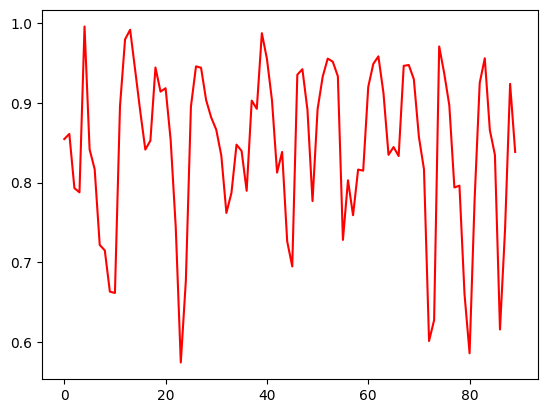

90 90


In [52]:
import matplotlib.pyplot as plt

# plt.plot(scaler_y.inverse_transform(y))

# plt.plot(trainPredictPlot,'g')
plt.plot(testPredict,'r')
#plt.plot(y_test)
plt.show()
print(len(y_test),len(testPredict))

In [53]:
# X_test_sequences.shape
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score


In [54]:
r2

-0.035057111336360025

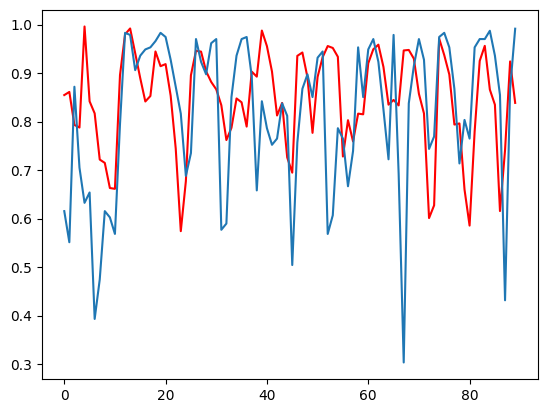

90 90


In [55]:
import matplotlib.pyplot as plt

# plt.plot(scaler_y.inverse_transform(y))

# plt.plot(trainPredict,'g')
plt.plot(testPredict,'r')
plt.plot(y_test)
plt.show()
print(len(y_test),len(testPredict))

In [56]:
len(y_test)

90